<h1>Predicting the crime rate based on the venues categories prevailing in London boroughs</h1>

## 1. Data Collection and Enrichment

### Recorded Crime Feed

#### Download file from London Data Store Portal https://data.london.gov.uk/dataset/recorded_crime_summary

In [1]:
!wget -q -O 'recorded_crimes_feed.csv' https://data.london.gov.uk/download/recorded_crime_summary/866c05de-c5cd-454b-8fe5-9e7c77ea2313/MPS%20Ward%20Level%20Crime%20%28most%20recent%2024%20months%29.csv
print('Recorded Crime Feed downloaded!')

Recorded Crime Feed downloaded!


#### Load and prepare data

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

crimes_df = pd.read_csv('recorded_crimes_feed.csv')

# Selected parameters
selected_category = "Violence Against the Person" 
#selected_category = "Theft"
selected_year = "2019"

selected_months = ["{}{:02d}".format(selected_year,i) for i in range(1,13)]  # getting all months of selected year

crimes_df = crimes_df[crimes_df["MajorText"]==selected_category]
crimes_df["crime_count"] = crimes_df[selected_months].sum(axis=1)
recorded_crimes_df = crimes_df.groupby(["LookUp_BoroughName","WardName","WardCode"])[["crime_count"]].agg("sum")
recorded_crimes_df.reset_index(inplace=True)
print(recorded_crimes_df.shape)
recorded_crimes_df.head()

(632, 4)


,LookUp_BoroughName,WardName,WardCode,crime_count
0,Barking and Dagenham,Abbey,E05000026,694
1,Barking and Dagenham,Alibon,E05000027,307
2,Barking and Dagenham,Becontree,E05000028,366
3,Barking and Dagenham,Chadwell Heath,E05000029,357
4,Barking and Dagenham,Eastbrook,E05000030,292


### Population Density Feed

#### Download file from London Data Store Portal  https://data.london.gov.uk/dataset/land-area-and-population-density-ward-and-borough

In [3]:
!wget -q -O 'population_feed.csv' https://data.london.gov.uk/download/land-area-and-population-density-ward-and-borough/d961f13b-6726-4fa8-823f-03b379429b72/housing-density-ward.csv
print('Population Density Feed downloaded!')

Population Density Feed downloaded!


#### Load and prepare data

In [4]:
population_df = pd.read_csv('population_feed.csv')
population_df = population_df[population_df["Year"]==int(selected_year)]  # only interested in selected year data
print(population_df.shape)
population_df.head()

(624, 9)


,Code,Borough,Ward_Name,Year,Population,Hectares,Square_Kilometres,Population_per_hectare,Population_per_square_kilometre
4992,E05000026,Barking and Dagenham,Abbey,2019,15518,127.9,1.279,121.329163,12132.916340
4993,E05000027,Barking and Dagenham,Alibon,2019,11289,136.1,1.361,82.946363,8294.636297
4994,E05000028,Barking and Dagenham,Becontree,2019,15118,128.4,1.284,117.741433,11774.143300
4995,E05000029,Barking and Dagenham,Chadwell Heath,2019,11405,338.0,3.380,33.742604,3374.260355
4996,E05000030,Barking and Dagenham,Eastbrook,2019,11144,345.4,3.454,32.264042,3226.404169


#### Join two data feed to compute crime rate

Some records from recorded crimes feed don't have corresponding records with population, we need to filter them out from our clean data

In [5]:
crime_rate_df = recorded_crimes_df.merge(right=population_df,how='left',left_on=["LookUp_BoroughName","WardName"],right_on=["Borough","Ward_Name"])
print(crime_rate_df.shape)
crime_rate_df = crime_rate_df[crime_rate_df["Population"].notnull()]  # cleaning not matched records
print(crime_rate_df.shape)
crime_rate_df['crime_rate'] = 1000*crime_rate_df['crime_count'].div(crime_rate_df['Population'])
crime_rate_df= crime_rate_df[['LookUp_BoroughName','WardName','WardCode','crime_rate']]

crime_rate_df.sort_values(by='crime_rate').head()

(632, 13)
(557, 13)


,LookUp_BoroughName,WardName,WardCode,crime_rate
561,Tower Hamlets,Limehouse,E05009326,5.616272
494,Richmond upon Thames,East Sheen,E05000517,6.085011
103,Camden,Frognal and Fitzjohns,E05000133,7.856988
274,Harrow,Pinner South,E05000298,7.918240
97,Bromley,West Wickham,E05000127,8.392342


### Geographical coordinates of London wards

We are going to use 'MapIt' API to get the corrdinates for London wards. It's possible to register on their website for free for a non-profit projects.

In [6]:
!conda install -c conda-forge bs4 --yes


from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import requests

API_KEY = "pvssREKsieXHEh5eDArqZcNeNeYRX4dgDyidarPM"


url_template = "https://mapit.mysociety.org/area/{}.html?api_key="+API_KEY
json_link = "https://mapit.mysociety.org{}?api_key="+API_KEY

geolocation_df = pd.read_csv('geolocation.csv')
#geolocation_df = pd.DataFrame(columns=['WardCode','Latitude','Longitude'])




for ward_code in crime_rate_df['WardCode']:    
    if ward_code.strip() not in geolocation_df['WardCode'].tolist():
        print("Ward {} processing started".format(ward_code))
        req = Request(url_template.format(ward_code))
        con = urlopen(req)                
        soup = BeautifulSoup(con)    
        section_node = soup.find("section", {"class": "details"})
        a_node = section_node.find("a")          
        print(json_link.format(a_node["href"]))
        json_req = requests.get(json_link.format(a_node["href"]))        
        print(json_req.status_code)
        json_data = json_req.json()                    
        new_row = pd.DataFrame([[ward_code,json_data['centre_lat'],json_data['centre_lon']]],columns=['WardCode','Latitude','Longitude'])
        geolocation_df = geolocation_df.append(new_row)
        geolocation_df.to_csv('geolocation.csv',index=False)  
        print("Ward {} processing finished".format(ward_code))

    
      
geolocation_df.head()

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - bs4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.9.0       |   py36h9f0ad1d_0         160 KB  conda-forge
    bs4-4.9.0                  |                0           4 KB  conda-forge
    soupsieve-1.9.4            |   py36h9f0ad1d_1          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         222 KB

The following NEW packages will be INSTALLED:

  beautifulsoup4     conda-forge/linux-64::beautifulsoup4-4.9.0-py36h9f0ad1d_0
  bs4                conda-forge/noarch::bs4-4.9.0-0
  soupsieve          conda-forge/linux-64::soupsieve-1.9.4-py36h9f0ad1d_1



soupsieve-1.9.4      | 58 KB     | ##################################### | 100% 
beautifuls

,WardCode,Latitude,Longitude
0,E05000026,51.539711,0.077935
1,E05000027,51.545589,0.148270
2,E05000028,51.554534,0.118957
3,E05000029,51.584751,0.139985
4,E05000030,51.553648,0.173581


Let's see these points allocated to the map of London

In [ ]:
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

RADIUS = 1000

# create map of London (coordinate taken from google)
map_london = folium.Map(location=[51.5074, 0.1278], zoom_start=10)

# add markers to map
for lat, lng, wardcode in zip(geolocation_df['Latitude'], geolocation_df['Longitude'], geolocation_df['WardCode']):
    label = '{}'.format(wardcode)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=RADIUS,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london


### Venues information

Let's set up Foursquare API

In [62]:
CLIENT_ID = 'QKKBSC4GPTTX0IZTYUTB3HJHFESQNDURYLNSRGIN3Y3WWKWL' # your Foursquare ID
CLIENT_SECRET = 'FTUQ5WPS2DKS0IS4V0JZTD51EOSFOCC40LZHVNAF1KUQCSC0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QKKBSC4GPTTX0IZTYUTB3HJHFESQNDURYLNSRGIN3Y3WWKWL
CLIENT_SECRET:FTUQ5WPS2DKS0IS4V0JZTD51EOSFOCC40LZHVNAF1KUQCSC0


..and collect all the information

In [63]:
import requests
LIMIT = 100

RADIUS = 500

def getNearbyVenues(names, latitudes, longitudes, radius=500):    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)                    
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION,lat,lng,radius,LIMIT)
        req = requests.get(url)        
        results = req.json()["response"]['groups'][0]['items']
        if len(results)<20:
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION,lat,lng,radius*2,LIMIT)
            req = requests.get(url)        
            results = req.json()["response"]['groups'][0]['items']     
            if len(results)<20:
                url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION,lat,lng,radius*3,LIMIT)
                req = requests.get(url)        
                results = req.json()["response"]['groups'][0]['items']    
                if len(results)<20:
                    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION,lat,lng,radius*4,LIMIT)
                    req = requests.get(url)        
                    results = req.json()["response"]['groups'][0]['items']  
                    if len(results)<20:
                        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION,lat,lng,radius*5,LIMIT)
                        req = requests.get(url)        
                        results = req.json()["response"]['groups'][0]['items']  
            if len(results)<20:
                print("Not enough!")
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['WardCode','Ward Latitude', 'Ward Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    return(nearby_venues)

london_venues = pd.read_csv('london_venues_new2.csv')
#london_venues = pd.DataFrame()

if len(london_venues)==0:
    london_venues = getNearbyVenues(names=geolocation_df['WardCode'],latitudes=geolocation_df['Latitude'],longitudes=geolocation_df['Longitude'],radius=RADIUS)
london_venues.to_csv("london_venues_new2.csv",index=False)

london_venues.head()



,WardCode,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,E05000026,51.539711,0.077935,Barking Abbey,51.535352,0.076054,Park
1,E05000026,51.539711,0.077935,Barking Park,51.545217,0.086134,Park
2,E05000026,51.539711,0.077935,Cristina's,51.536523,0.076672,Steakhouse
3,E05000026,51.539711,0.077935,Nando's,51.539780,0.082297,Portuguese Restaurant
4,E05000026,51.539711,0.077935,The Gym London Barking,51.536193,0.078601,Gym


In [64]:
nbr_of_venues = len(london_venues)
nbr_of_cats = len(london_venues['Venue Category'].unique())
nbr_of_wards = len(london_venues['WardCode'].unique())
print("The result dataset counts:\n\t- number of wards: {}\n\t- number of venues: {}\n\t- number of categories: {}".format(nbr_of_wards,nbr_of_venues,nbr_of_cats))


The result dataset counts:
	- number of wards: 557
	- number of venues: 22862
	- number of categories: 444


#### Let's scrape categories tree from Foursquare website https://developer.foursquare.com/docs/build-with-foursquare/categories/

In [65]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import requests



categories_url = "https://developer.foursquare.com/docs/build-with-foursquare/categories/"


req = Request(categories_url)
con = urlopen(req)                
soup = BeautifulSoup(con)    

def process_level(ul_node, level_nbr=0, parent_category=None):
    results = []   
    li_nodes = ul_node.findAll("li", recursive=False)
    for li_node in li_nodes:        
        child_category = li_node.find("h3").text
        results.append([child_category if parent_category is None else parent_category, child_category,level_nbr])
        child_ul_node = li_node.find("ul")
        if child_ul_node is not None:
            results+= process_level(child_ul_node, level_nbr+1, child_category)
    return results

ul_node = soup.find("ul",attrs={"class":"VenueCategories__Wrapper-sc-1ysxg0y-0"})
categories_lst = process_level(ul_node)
       
categories_df = pd.DataFrame(categories_lst,columns=["ParentCat","ChildCat","Level"])
categories_df.head()


,ParentCat,ChildCat,Level
0,Arts & Entertainment,Arts & Entertainment,0
1,Arts & Entertainment,Amphitheater,1
2,Arts & Entertainment,Aquarium,1
3,Arts & Entertainment,Arcade,1
4,Arts & Entertainment,Art Gallery,1


#### Replacing granular venue categories with parent level categories

In [66]:
london_venues.head()
london_venues_parent_cat1 = london_venues.merge(right=categories_df,how='left',left_on="Venue Category",right_on="ChildCat")
london_venues_parent_cat2 = london_venues_parent_cat1.merge(right=categories_df,how='left',left_on="ParentCat",right_on="ChildCat")
london_venues_parent_cat3 = london_venues_parent_cat2.merge(right=categories_df,how='left',left_on="ParentCat_y",right_on="ChildCat")
london_venues_parent_cat4 = london_venues_parent_cat3.merge(right=categories_df,how='left',left_on="ParentCat",right_on="ChildCat",suffixes=('_1','_2'))
london_venues_parent_cat5 = london_venues_parent_cat4.merge(right=categories_df,how='left',left_on="ParentCat_2",right_on="ChildCat",suffixes=('_3','_4'))
london_venues_parent_cat5['ParentCat'].unique()

array(['Outdoors & Recreation', 'Food', 'Shop & Service',
       'Travel & Transport', 'Nightlife Spot', 'Arts & Entertainment',
       'Professional & Other Places', 'College & University', 'Residence'],
      dtype=object)

In [67]:
london_venues_parent_cat = london_venues_parent_cat5

nbr_of_venues = len(london_venues_parent_cat)
nbr_of_cats = len(london_venues_parent_cat['ParentCat'].unique())
nbr_of_wards = len(london_venues_parent_cat['WardCode'].unique())
print("The result dataset counts:\n\t- number of wards: {}\n\t- number of venues: {}\n\t- number of categories: {}".format(nbr_of_wards,nbr_of_venues,nbr_of_cats))
london_venues_parent_cat['ParentCat'].unique()



The result dataset counts:
	- number of wards: 557
	- number of venues: 22862
	- number of categories: 9


array(['Outdoors & Recreation', 'Food', 'Shop & Service',
       'Travel & Transport', 'Nightlife Spot', 'Arts & Entertainment',
       'Professional & Other Places', 'College & University', 'Residence'],
      dtype=object)

## 2. Analyze data

### Clustering by crime rate 

In [68]:
#london_ward_grouped.drop(axis=1,columns=["Cluster Labels"],inplace=True)
from sklearn.cluster import KMeans

kclusters = 3

final_df_crime_rate = crime_rate_df.filter(['crime_rate'],axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(final_df_crime_rate)

# add clustering labels
#crime_rate_df.drop(columns=['crime_rate_category'],axis=1,inplace=True)
crime_rate_df.insert(0, 'crime_rate_category', kmeans.labels_)

for i in  range(0,kclusters):    
    print(i)
    print("min:"+str(crime_rate_df[crime_rate_df['crime_rate_category']==i]['crime_rate'].min()))
    print("max:"+str(crime_rate_df[crime_rate_df['crime_rate_category']==i]['crime_rate'].max()))
    print("size:"+str(len(crime_rate_df[crime_rate_df['crime_rate_category']==i]['crime_rate'])))

crime_rate_df[crime_rate_df['crime_rate_category']==1]

0
min:24.75189725627554
max:68.20143884892087
size:202
1
min:154.1342341019239
max:184.3774781919112
size:2
2
min:5.616272009714633
max:24.647167109838414
size:353


,crime_rate_category,LookUp_BoroughName,WardName,WardCode,crime_rate
626,1,Westminster,St James's,E05000644,184.377478
630,1,Westminster,West End,E05000649,154.134234


Only 2 wards are in super high rate - let's exclude them and do clustering again

In [69]:
crime_rate_df = crime_rate_df[crime_rate_df['crime_rate_category']!=1]
kclusters = 3

final_df_crime_rate = crime_rate_df.filter(['crime_rate'],axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(final_df_crime_rate)

# add clustering labels
crime_rate_df.drop(columns=['crime_rate_category'],axis=1,inplace=True)
crime_rate_df.insert(0, 'crime_rate_category', kmeans.labels_)

for i in  range(0,kclusters):    
    print(i)
    print("min:"+str(crime_rate_df[crime_rate_df['crime_rate_category']==i]['crime_rate'].min()))
    print("max:"+str(crime_rate_df[crime_rate_df['crime_rate_category']==i]['crime_rate'].max()))
    print("size:"+str(len(crime_rate_df[crime_rate_df['crime_rate_category']==i]['crime_rate'])))



0
min:5.616272009714633
max:21.264063144253992
size:272
1
min:21.36829964183816
max:35.35722994391612
size:242
2
min:35.77635284952358
max:68.20143884892087
size:41


In [70]:
import numpy as np
crime_rate_df['crime_rate_cat_name'] = np.empty(shape=(len(crime_rate_df),1),dtype=str)
crime_rate_df.loc[crime_rate_df['crime_rate_category']==0,'crime_rate_cat_name'] = 'Low'
crime_rate_df.loc[crime_rate_df['crime_rate_category']==1,'crime_rate_cat_name'] = 'Medium'
crime_rate_df.loc[crime_rate_df['crime_rate_category']==2,'crime_rate_cat_name'] = 'High'
crime_rate_df.drop(columns="crime_rate_category",inplace=True)
crime_rate_df.rename(columns={"crime_rate_cat_name":"crime_rate_category"},inplace=True)
crime_rate_df.head()

,LookUp_BoroughName,WardName,WardCode,crime_rate,crime_rate_category
0,Barking and Dagenham,Abbey,E05000026,44.722258,High
1,Barking and Dagenham,Alibon,E05000027,27.194614,Medium
2,Barking and Dagenham,Becontree,E05000028,24.209552,Medium
3,Barking and Dagenham,Chadwell Heath,E05000029,31.302060,Medium
4,Barking and Dagenham,Eastbrook,E05000030,26.202441,Medium


### Clustering by categories

In [71]:
london_venues_parent_cat = london_venues_parent_cat[london_venues_parent_cat['WardCode']!='E05000649']
london_venues_parent_cat = london_venues_parent_cat[london_venues_parent_cat['WardCode']!='E05000644']

london_venues_onehot = pd.get_dummies(london_venues_parent_cat[['ParentCat']],prefix="",prefix_sep="")
london_venues_onehot['WardCode'] = london_venues_parent_cat['WardCode']
london_ward_grouped = london_venues_onehot.groupby('WardCode').mean().reset_index()
london_ward_grouped.head()


,WardCode,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,E05000026,0.055556,0.0,0.250000,0.027778,0.138889,0.000000,0.0,0.361111,0.166667
1,E05000027,0.068182,0.0,0.181818,0.068182,0.250000,0.000000,0.0,0.363636,0.068182
2,E05000028,0.043478,0.0,0.217391,0.043478,0.304348,0.000000,0.0,0.304348,0.086957
3,E05000029,0.057143,0.0,0.285714,0.085714,0.142857,0.028571,0.0,0.314286,0.085714
4,E05000030,0.000000,0.0,0.236842,0.052632,0.315789,0.000000,0.0,0.368421,0.026316


In [20]:
#london_ward_grouped.drop(axis=1,columns=["Cluster Labels"],inplace=True)
from sklearn.cluster import KMeans

kclusters = 10

london_ward__grouped_clustering = london_ward_grouped.drop('WardCode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_ward__grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
#london_ward_grouped.drop(columns=['Cluster Labels'],axis=1,inplace=True)
london_ward_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

london_ward_grouped.head()




,Cluster Labels,WardCode,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,1,E05000026,0.055556,0.0,0.250000,0.027778,0.138889,0.000000,0.0,0.361111,0.166667
1,2,E05000027,0.068182,0.0,0.181818,0.068182,0.250000,0.000000,0.0,0.363636,0.068182
2,2,E05000028,0.043478,0.0,0.217391,0.043478,0.304348,0.000000,0.0,0.304348,0.086957
3,1,E05000029,0.057143,0.0,0.285714,0.085714,0.142857,0.028571,0.0,0.314286,0.085714
4,2,E05000030,0.000000,0.0,0.236842,0.052632,0.315789,0.000000,0.0,0.368421,0.026316


Join it to the crime rate data set

In [21]:
final_df = crime_rate_df.merge(right=london_ward_grouped,how='left',)
final_df = final_df[final_df['Food'].notnull()]
final_df.sort_values(by=['crime_rate'],inplace=True)
for col in final_df.columns:   
    if "&" in col:        
        final_df.rename(columns={col:col.replace("&","and")},inplace=True)
final_df.head()

,LookUp_BoroughName,WardName,WardCode,crime_rate,crime_rate_category,Cluster Labels,Arts and Entertainment,College and University,Food,Nightlife Spot,Outdoors and Recreation,Professional and Other Places,Residence,Shop and Service,Travel and Transport
493,Tower Hamlets,Limehouse,E05009326,5.616272,Low,9,0.043478,0.0,0.478261,0.086957,0.260870,0.000000,0.0,0.043478,0.086957
449,Richmond upon Thames,East Sheen,E05000517,6.085011,Low,9,0.000000,0.0,0.300000,0.150000,0.500000,0.000000,0.0,0.050000,0.000000
95,Camden,Frognal and Fitzjohns,E05000133,7.856988,Low,5,0.060606,0.0,0.636364,0.090909,0.060606,0.030303,0.0,0.121212,0.000000
239,Harrow,Pinner South,E05000298,7.918240,Low,0,0.000000,0.0,0.446809,0.148936,0.127660,0.000000,0.0,0.234043,0.042553
89,Bromley,West Wickham,E05000127,8.392342,Low,1,0.000000,0.0,0.363636,0.090909,0.136364,0.000000,0.0,0.363636,0.045455


In [22]:
import numpy as np
df_for_plot = pd.DataFrame(columns=range(0,kclusters))

for cl in range(0,kclusters):  
    selected_for_cluster = final_df[final_df['Cluster Labels']==cl]['crime_rate']    
    a = np.empty(shape=(len(selected_for_cluster),kclusters))
    a[:] = np.nan
    new_df = pd.DataFrame(a, columns=range(0,kclusters))
    new_df[cl]  = list(selected_for_cluster)   
    df_for_plot = df_for_plot.append(new_df)
df_for_plot.head()

,0,1,2,3,4,5,6,7,8,9
0,7.918240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9.300477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.005053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10.587020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.806051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.1.1


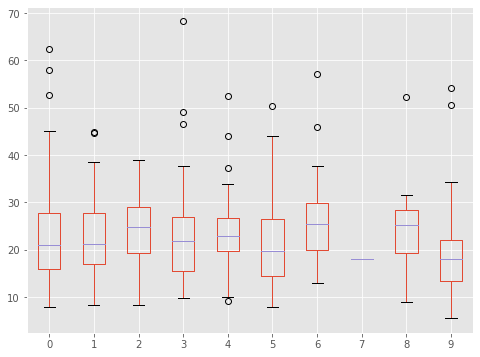

In [24]:

df_for_plot.plot(kind='box', figsize=(8, 6))
plt.show()


In [25]:
cluster_9 = final_df[final_df['Cluster Labels']==9]
cluster_9.sum()[5:].sort_values(ascending=False)[0:20]

Cluster Labels                         351
Food                               14.7979
Outdoors and Recreation            11.0831
Shop and Service                   5.08938
Nightlife Spot                     4.01753
Travel and Transport               2.77058
Arts and Entertainment              1.1301
Professional and Other Places    0.0757206
College and University           0.0357143
Residence                                0
dtype: object

In [26]:
cluster_6 = final_df[final_df['Cluster Labels']==6]
cluster_6.sum()[5:].sort_values(ascending=False)[0:20]

Cluster Labels                        306
Shop and Service                  23.4995
Food                              15.8914
Outdoors and Recreation           4.30449
Travel and Transport              3.85735
Nightlife Spot                    2.20205
Arts and Entertainment            1.00987
Professional and Other Places    0.150621
Residence                        0.047619
College and University           0.037037
dtype: object

In [27]:
final_df[final_df['Cluster Labels']==7]


,LookUp_BoroughName,WardName,WardCode,crime_rate,crime_rate_category,Cluster Labels,Arts and Entertainment,College and University,Food,Nightlife Spot,Outdoors and Recreation,Professional and Other Places,Residence,Shop and Service,Travel and Transport
341,Kingston upon Thames,Chessington South,E05000405,18.152408,Low,7,0.782609,0.0,0.086957,0.043478,0.0,0.0,0.0,0.0,0.086957


Excluding E05000405 also

In [28]:
final_df = final_df[final_df['WardCode']!='E05000405']

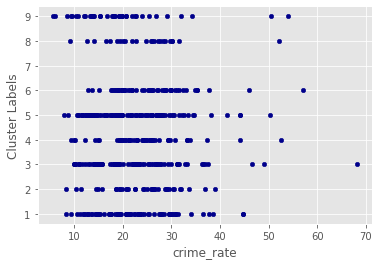

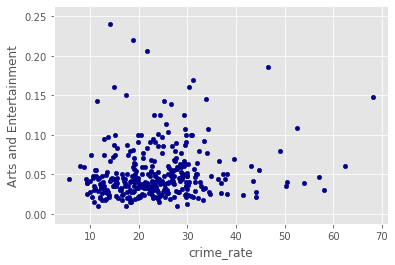

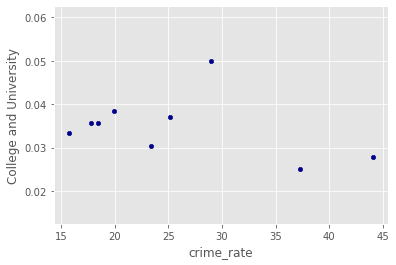

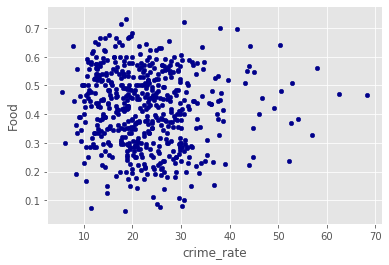

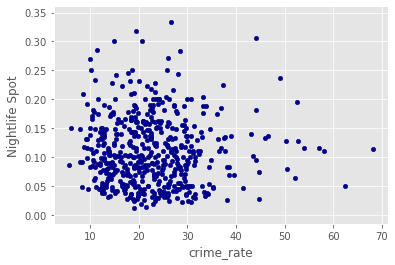

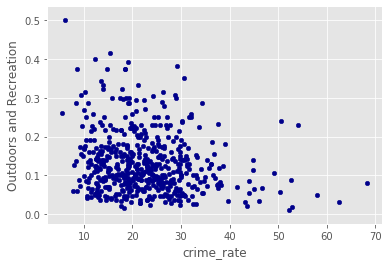

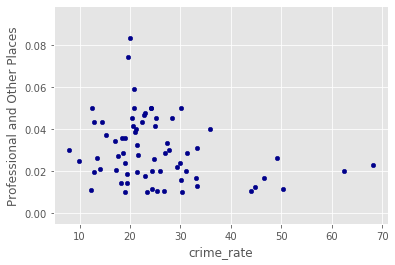

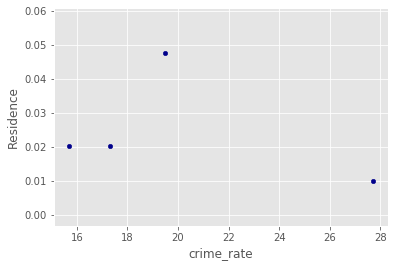

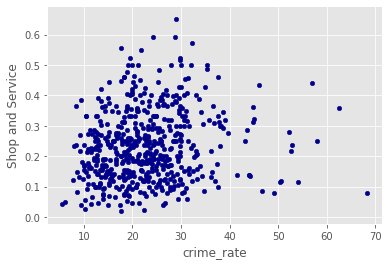

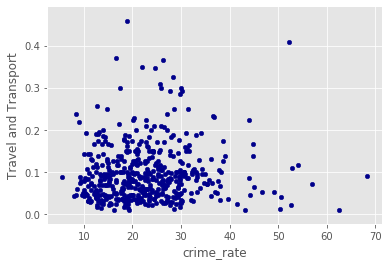

In [29]:
for col in final_df.columns[5:]:
    final_df[final_df[col]>0].plot.scatter(x='crime_rate',y=col,c='DarkBlue')


### Building Decision Tree Model

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

y = final_df['crime_rate_category']
selected_columns=final_df.columns[5:-1]
X = final_df[selected_columns]

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

crimeRateTree = DecisionTreeClassifier(criterion="entropy", max_depth =4 )

crimeRateTree.fit(X_trainset,y_trainset)

predCrimeRate = crimeRateTree.predict(X_testset)

from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predCrimeRate))



DecisionTrees's Accuracy:  0.49101796407185627


### Visualisation

In [231]:
# Notice: You might need to uncomment and install the pydotplus and graphviz libraries if you have not installed these before
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y

In [332]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

In [330]:
dot_data = StringIO()
filename = "crimeRateTree.png"
featureNames = selected_columns
targetNames = y.unique().tolist()
out=tree.export_graphviz(crimeRateTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
#img = mpimg.imread(filename)
#plt.figure(figsize=(100, 200))
#plt.imshow(img,interpolation='nearest')


True

## Support Vector Machines

In [37]:

y = final_df['crime_rate_category']
selected_columns=final_df.columns[5:-1]
X = final_df[selected_columns]

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

from sklearn import svm
crRateSVM = svm.SVC(kernel='rbf')
crRateSVM.fit(X_trainset, y_trainset) 
yhat = crRateSVM.predict(X_testset)

from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_testset, yhat)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.4431137724550898

In [33]:
from sklearn.metrics import f1_score
f1_score(y_testset, yhat, average='weighted') 

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.4211793803696954

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

        High       0.00      0.00      0.00        12
         Low       0.46      0.58      0.51        81
      Medium       0.42      0.36      0.39        74

   micro avg       0.44      0.44      0.44       167
   macro avg       0.29      0.32      0.30       167
weighted avg       0.41      0.44      0.42       167

Confusion matrix, without normalization
[[47 34  0]
 [47 27  0]
 [ 9  3  0]]


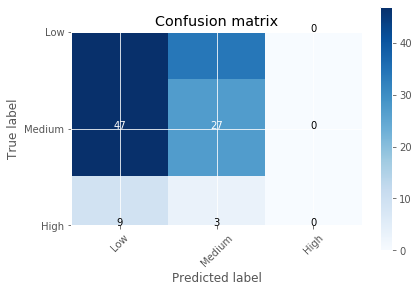

In [41]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_testset, yhat, labels=['Low','Medium','High'])
np.set_printoptions(precision=2)

print (classification_report(y_testset, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Low','Medium','High'],normalize= False,  title='Confusion matrix')